# Project Introduction

**Title:** Operational Efficiency & Customer Behavior - Olist (Brazil)

### **Scope & objective**  
This notebook evaluates Olist’s order-to-delivery workflow and customer payment behavior. Primary aims are to quantify operational performance (approval latency, end-to-end delivery speed, adherence to estimated delivery windows), identify high-impact bottlenecks, and produce actionable, measurable recommendations to improve fulfillment and customer satisfaction.

### **Data & methods**  
- **Data sources:** Orders, Customers, and Order Payments tables from the Olist public dataset.  
- **Data preparation:** Deterministic joins and aggregation to create one record per order; standardized column names; robust datetime parsing; duplicate removal; and restriction to completed (delivered) transactions for delivery-performance analysis.  
- **Feature engineering:** Key derived metrics include `approval_lag_hours`, `delivery_speed_days`, `performance_delta_days`, `is_weekend`, and `payment_value_per_installment`.  
- **Analytical approach:** Descriptive statistics (median and high-percentile focus), distribution and outlier analysis, bivariate diagnostics (regression where appropriate), and time-series aggregation for capacity planning.

### **Assumptions & limitations**  
- Delivery analyses exclude orders without a confirmed `order_delivered_customer_date` to avoid MNAR bias.  
- Conservative imputations are documented in the cleaning cells (e.g., missing `order_approved_at` may be imputed to `order_purchase_timestamp` where justified).  
- Results are exploratory and diagnostic; causal claims require controlled experiments or richer operational telemetry.

### **Deliverable**  
A reproducible, analysis-ready notebook that provides 
(1) a cleaned dataset suitable for modeling and dashboards, 
(2) diagnostic visualizations and statistics highlighting operational weaknesses,
(3) prioritized, measurable recommendations for operational improvement.


### 1. Setup and Library Imports
We import Python libraries required for data handling, analysis, and visualization.


In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


### 2. Load Core Datasets
Load customers, orders, and payments data.  
We use three tables for this analysis:
- `olist_customers_dataset.csv`
- `olist_orders_dataset.csv`
- `olist_order_payments_dataset.csv`


In [283]:
# Load datasets (update paths to your environment)
df_customers = pd.read_csv(r"C:\Users\BDO NARKANDA\Downloads\archive\olist_customers_dataset.csv")
df_orders = pd.read_csv(r"C:\Users\BDO NARKANDA\Downloads\archive\olist_orders_dataset.csv")
df_payments = pd.read_csv(r"C:\Users\BDO NARKANDA\Downloads\archive\olist_order_payments_dataset.csv")

print(df_orders.shape, df_customers.shape, df_payments.shape)


(99441, 8) (99441, 5) (103886, 5)


### 3. Data Integration
We merge:
1. Orders ↔ Customers (using `customer_id`)
2. Orders ↔ Payments (using `order_id`)


In [284]:
# Merge orders with customers
df_merged = pd.merge(df_orders, df_customers, on='customer_id', how='inner')
print("After merging orders & customers:", df_merged.shape)


After merging orders & customers: (99441, 12)


In [285]:
# Aggregate payments per order to ensure a clean 1:1 relationship
df_pay_agg = df_payments.groupby('order_id').agg(
    total_payment_value=('payment_value', 'sum'),
    total_installments=('payment_installments', 'sum'),
    payment_type=('payment_type', lambda x: x.mode()[0])
).reset_index()

# Rename for clarity
df_pay_agg.rename(columns={'total_payment_value': 'payment_value'}, inplace=True)
print("Aggregated payments shape:", df_pay_agg.shape)
# Aggregate payments per order to ensure a clean 1:1 relationship
df_pay_agg = df_payments.groupby('order_id').agg(
    total_payment_value=('payment_value', 'sum'),
    total_installments=('payment_installments', 'sum'),
    payment_type=('payment_type', lambda x: x.mode()[0])
).reset_index()




Aggregated payments shape: (99440, 4)


In [286]:
# Merge aggregated payments
df_final = pd.merge(df_merged, df_pay_agg, on='order_id', how='left')
print("Final merged dataset shape:", df_final.shape)


Final merged dataset shape: (99441, 15)


### 4. Clean Column Names
Convert all column headers to lowercase with underscores (Pythonic format).


In [287]:
def clean_columns(df):
    df.columns = [col.lower().replace(' ', '_').replace('-', '_') for col in df.columns]
    return df

df_final = clean_columns(df_final)


### 5. Convert String Dates to Datetime
Convert timestamp columns to Pandas datetime type for proper time calculations.


In [288]:
datetime_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in datetime_cols:
    df_final[col] = pd.to_datetime(df_final[col], errors='coerce')


### 6. Remove Duplicate Orders
Ensure each order is unique using key identifiers.


In [289]:
before = df_final.shape[0]
df_final.drop_duplicates(subset=['order_id', 'customer_id', 'order_purchase_timestamp'], inplace=True)
after = df_final.shape[0]
print(f"Removed {before-after} duplicates; new shape: {df_final.shape}")


Removed 0 duplicates; new shape: (99441, 15)


### 7. Handle Missing Values
We fix missing entries logically:
- Fill `order_approved_at` using purchase timestamp  
- Drop one missing carrier date  
- Fill payment-related nulls with median/mode defaults  
- Recalculate dependent metrics  


In [290]:
# Fill missing approval timestamps with purchase time (assume instant approval)
if 'order_approved_at' in df_final.columns:
    df_final['order_approved_at'].fillna(df_final['order_purchase_timestamp'], inplace=True)

# Drop rows missing carrier delivery date (rare but essential)
if 'order_delivered_carrier_date' in df_final.columns:
    df_final.dropna(subset=['order_delivered_carrier_date'], inplace=True)

# Fix potential naming differences
if 'payment_installments' in df_final.columns and 'total_installments' not in df_final.columns:
    df_final.rename(columns={'payment_installments': 'total_installments'}, inplace=True)

if 'total_payment_value' in df_final.columns and 'payment_value' not in df_final.columns:
    df_final.rename(columns={'total_payment_value': 'payment_value'}, inplace=True)

# Fill missing payment fields
if 'payment_value' in df_final.columns:
    df_final['payment_value'].fillna(df_final['payment_value'].median(), inplace=True)

if 'total_installments' in df_final.columns:
    df_final['total_installments'].fillna(1, inplace=True)

if 'payment_type' in df_final.columns:
    df_final['payment_type'].fillna(df_final['payment_type'].mode()[0], inplace=True)

# --- Recalculate dependent engineered features ---
if all(col in df_final.columns for col in ['order_approved_at', 'order_purchase_timestamp']):
    df_final['approval_lag'] = df_final['order_approved_at'] - df_final['order_purchase_timestamp']
    df_final['approval_lag_hours'] = df_final['approval_lag'].dt.total_seconds() / 3600

if all(col in df_final.columns for col in ['payment_value', 'total_installments']):
    df_final['payment_value_per_installment'] = df_final['payment_value'] / df_final['total_installments']

# --- Check remaining nulls ---
print("Remaining nulls:")
print(df_final.isnull().sum()[df_final.isnull().sum() > 0])


Remaining nulls:
order_delivered_customer_date    1183
dtype: int64


C:\Users\BDO NARKANDA\AppData\Local\Temp\ipykernel_21176\3576782594.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['order_approved_at'].fillna(df_final['order_purchase_timestamp'], inplace=True)
C:\Users\BDO NARKANDA\AppData\Local\Temp\ipykernel_21176\3576782594.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which w

### 8. Filter Out Undelivered Orders
Remove rows with missing customer delivery timestamps to ensure accurate delivery metrics.


In [291]:
print("Before:", df_final.shape)
df_final = df_final[~df_final['order_delivered_customer_date'].isnull()].copy()
print("After filtering undelivered:", df_final.shape)


Before: (97658, 18)
After filtering undelivered: (96475, 18)


### 9. Feature Engineering
We extract new insights:
- Calendar components  
- Weekend indicator  
- Delivery speed and performance metrics  
- Approval lag  


In [292]:
# Calendar features
df_final['purchase_year'] = df_final['order_purchase_timestamp'].dt.year
df_final['purchase_month'] = df_final['order_purchase_timestamp'].dt.month
df_final['purchase_dayofweek'] = df_final['order_purchase_timestamp'].dt.day_name()
df_final['purchase_hour'] = df_final['order_purchase_timestamp'].dt.hour

# Weekend indicator
weekend_days = ['Saturday', 'Sunday']
df_final['is_weekend'] = df_final['purchase_dayofweek'].isin(weekend_days).astype(int)


In [293]:
# Operational timings
df_final['approval_lag_hours'] = (df_final['order_approved_at'] - df_final['order_purchase_timestamp']).dt.total_seconds() / 3600
df_final['delivery_speed_days'] = (df_final['order_delivered_customer_date'] - df_final['order_purchase_timestamp']).dt.total_seconds() / (3600*24)
df_final['performance_delta_days'] = (df_final['order_estimated_delivery_date'] - df_final['order_delivered_customer_date']).dt.total_seconds() / (3600*24)

df_final[['approval_lag_hours','delivery_speed_days','performance_delta_days']].describe()


,approval_lag_hours,delivery_speed_days,performance_delta_days
count,96475.000000,96475.000000,96475.000000
mean,10.276241,12.558289,11.179306
std,20.534479,9.545715,10.186001
min,0.000000,0.533414,-188.975081
25%,0.215278,6.766395,6.390127
50%,0.343333,10.217500,11.948958
75%,14.514167,15.720237,16.244392
max,741.443611,209.628611,146.016123


### 10.1 Distribution of Delivery Speed
We visualize the spread of delivery times in days.


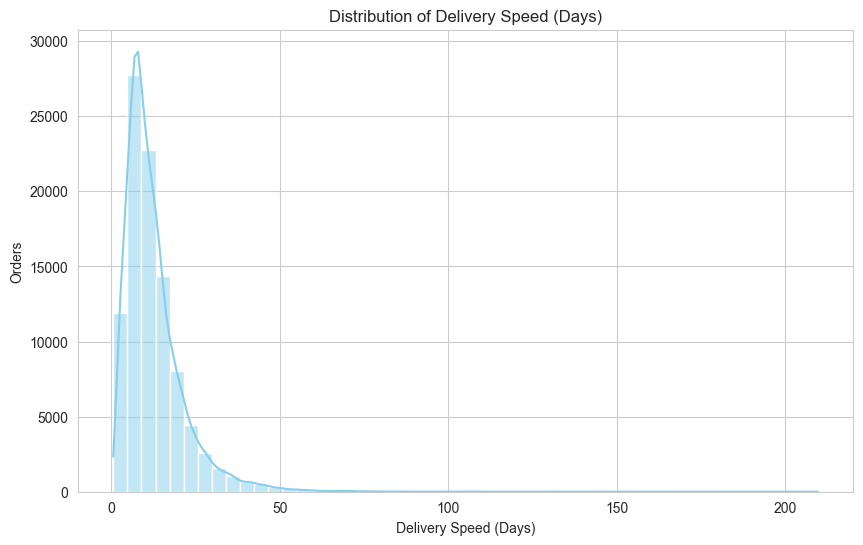

In [294]:
sns.histplot(df_final['delivery_speed_days'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Delivery Speed (Days)")
plt.xlabel("Delivery Speed (Days)")
plt.ylabel("Orders")
plt.show()


### 10.2 Payment Method Frequency
Shows the most used payment methods.


C:\Users\BDO NARKANDA\AppData\Local\Temp\ipykernel_21176\1787674861.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, y='payment_type', order=df_final['payment_type'].value_counts().index, palette='viridis')


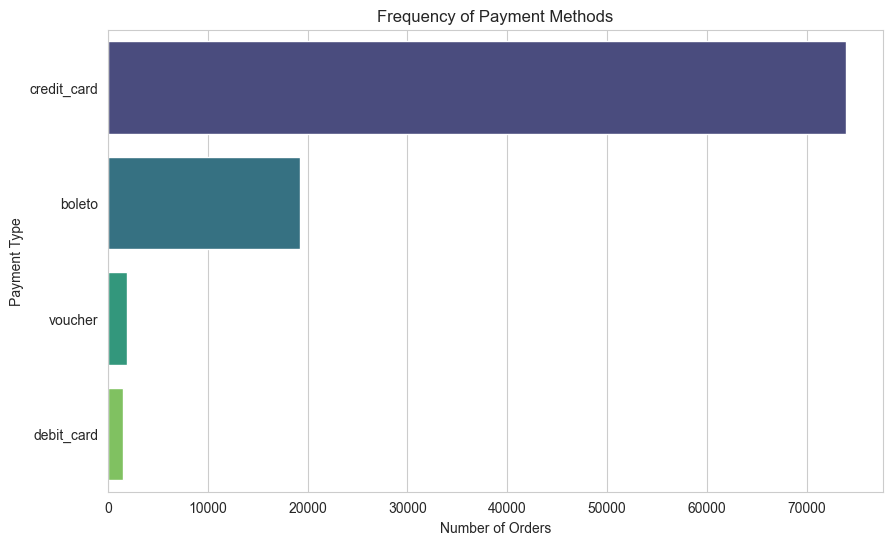

In [295]:
sns.countplot(data=df_final, y='payment_type', order=df_final['payment_type'].value_counts().index, palette='viridis')
plt.title("Frequency of Payment Methods")
plt.xlabel("Number of Orders")
plt.ylabel("Payment Type")
plt.show()


### 10.3 Delivery Speed vs Payment Value
Tests if expensive orders are delivered faster.


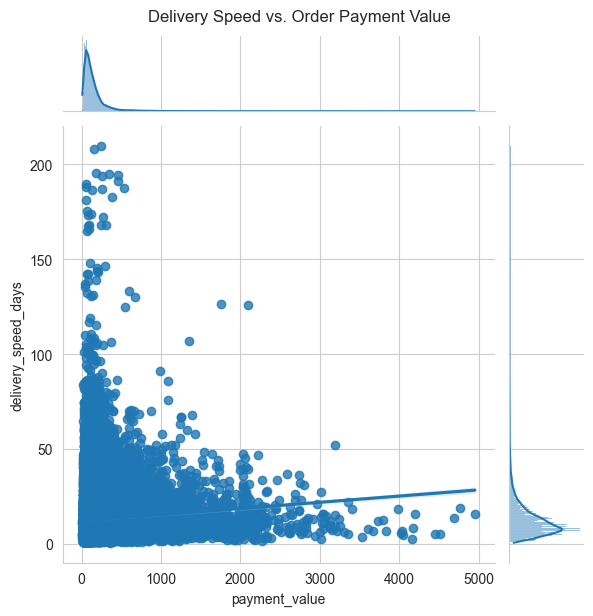

In [296]:
df_plot = df_final[df_final['payment_value'] < 5000]
sns.jointplot(x='payment_value', y='delivery_speed_days', data=df_plot, kind='reg', height=6)
plt.suptitle("Delivery Speed vs. Order Payment Value", y=1.02)
plt.show()


### 10.4 Payment Value by Method
Compares order values across payment types.


C:\Users\BDO NARKANDA\AppData\Local\Temp\ipykernel_21176\4191405151.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='payment_type', y='payment_value', data=df_final[df_final['payment_value'] < 1000], palette='Pastel1')


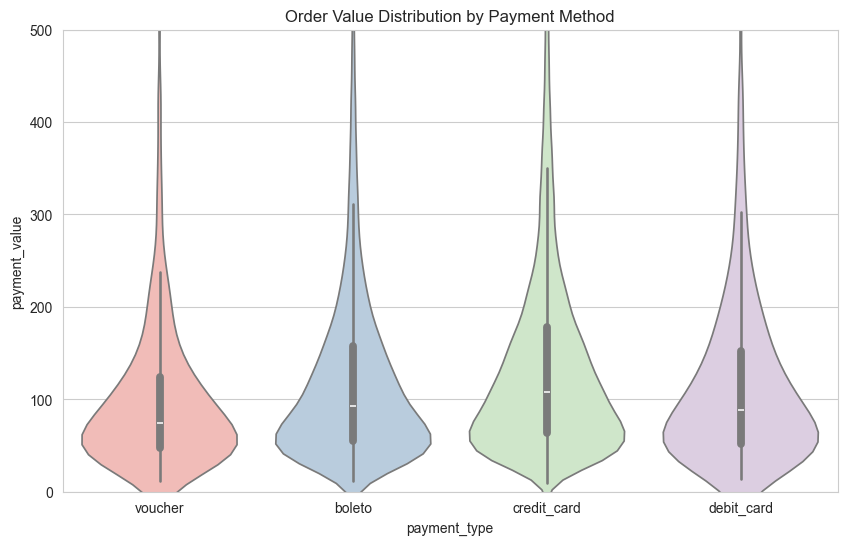

In [297]:
sns.violinplot(x='payment_type', y='payment_value', data=df_final[df_final['payment_value'] < 1000], palette='Pastel1')
plt.title("Order Value Distribution by Payment Method")
plt.ylim(0, 500)
plt.show()


### 10.5 Approval Lag: Weekday vs Weekend
Analyzes whether weekend orders take longer to approve.


C:\Users\BDO NARKANDA\AppData\Local\Temp\ipykernel_21176\3733518833.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='is_weekend', y='approval_lag_hours', data=df_final, ci=95, palette=['lightcoral','lightgreen'])
C:\Users\BDO NARKANDA\AppData\Local\Temp\ipykernel_21176\3733518833.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_weekend', y='approval_lag_hours', data=df_final, ci=95, palette=['lightcoral','lightgreen'])


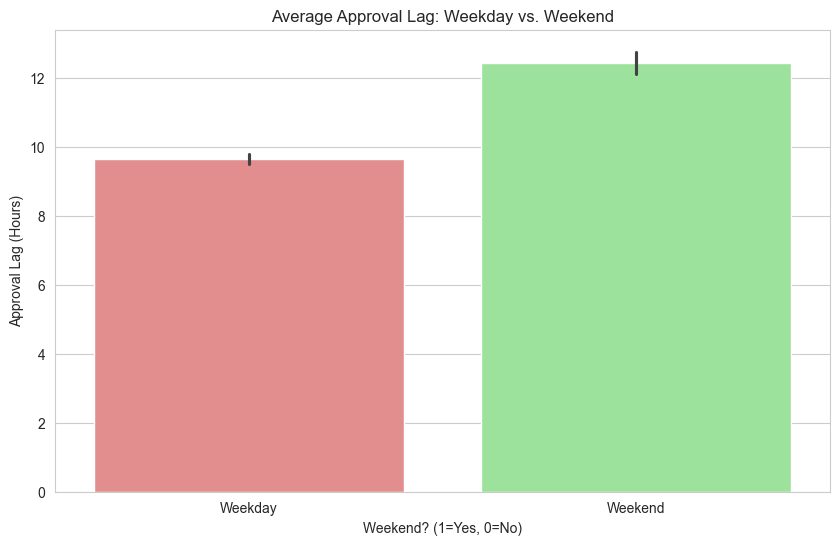

In [298]:
sns.barplot(x='is_weekend', y='approval_lag_hours', data=df_final, ci=95, palette=['lightcoral','lightgreen'])
plt.title("Average Approval Lag: Weekday vs. Weekend")
plt.xlabel("Weekend? (1=Yes, 0=No)")
plt.ylabel("Approval Lag (Hours)")
plt.xticks([0,1], ['Weekday','Weekend'])
plt.show()


### 10.6 Monthly Delivered Orders
Tracks delivery volume trends over time.


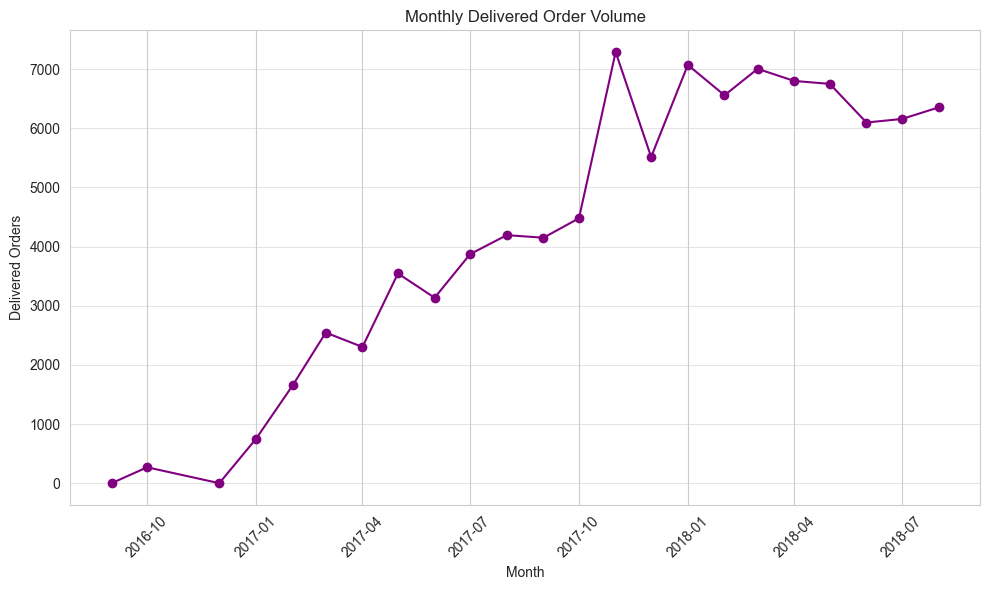

In [299]:
monthly = df_final.groupby(['purchase_year','purchase_month']).size().reset_index(name='order_count')
monthly['date'] = pd.to_datetime(monthly['purchase_year'].astype(str) + '-' + monthly['purchase_month'].astype(str) + '-01')
monthly = monthly.sort_values('date')

plt.plot(monthly['date'], monthly['order_count'], marker='o', color='purple')
plt.title("Monthly Delivered Order Volume")
plt.xlabel("Month")
plt.ylabel("Delivered Orders")
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [302]:
df_final.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 96475 entries, 0 to 99440
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   order_id                       96475 non-null  object         
 1   customer_id                    96475 non-null  object         
 2   order_status                   96475 non-null  object         
 3   order_purchase_timestamp       96475 non-null  datetime64[ns] 
 4   order_approved_at              96475 non-null  datetime64[ns] 
 5   order_delivered_carrier_date   96475 non-null  datetime64[ns] 
 6   order_delivered_customer_date  96475 non-null  datetime64[ns] 
 7   order_estimated_delivery_date  96475 non-null  datetime64[ns] 
 8   customer_unique_id             96475 non-null  object         
 9   customer_zip_code_prefix       96475 non-null  int64          
 10  customer_city                  96475 non-null  object         
 11  custome

## Key Insights & Recommendations

Analysis of Olist order, customer and payment records indicates a reasonable median delivery performance alongside a meaningful tail of late deliveries and a persistent weekend approval lag. Credit-card transactions (frequently with installments) dominate volume and larger order values, yet high-value orders do not receive prioritized logistics under current operations.

**Top insights (concise):**
- Delivery times are right-skewed: the median is reasonable, but the 95th percentile reveals critical outliers that harm the customer experience.  
- Approval lag is materially higher for weekend orders, indicating reduced processing capacity outside standard business days.  
- Credit/instalment payments account for the majority of volume and are associated with higher average order values.  
- There is no observable prioritization of high-value orders in delivery speed.

**Priority recommendations (high impact):**
1. **Target the delivery tail:** identify and remediate the top percentile of slow deliveries (segment by carrier, seller, SKU, and route).  
2. **Reduce weekend approval latency:** implement low-risk automation and/or adjust weekend staffing to shorten approval lag.  
3. **Pilot priority fulfilment for high-value orders:** offer paid or merchant-funded fast-shipping and measure delivery and retention lift.  
4. **Adopt percentile-based KPIs and alerts:** monitor median delivery time, 95th-percentile delivery time, median approval lag, and % orders meeting estimated delivery; surface automated alerts for breaches.

These initiatives should reduce customer friction, protect revenue from high-value customers, and improve operational resilience as order volume scales.
